<a href="https://colab.research.google.com/github/dilipkpgit/aiml-cv/blob/main/Project_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PART - A
• DOMAIN: Entertainment

• CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis.
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie
and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and
multimedia experts who need to detect faces from screen shots from the movie scene.The data labelling is already done. Since there higher time complexity is involved in the

• DATA DESCRIPTION: The dataset comprises of images and its mask for corresponding human face.

• PROJECT OBJECTIVE: To build a face detection system.

In [ ]:
#Standard operations
import numpy as np
import pandas as pd

# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

#Visualization
from matplotlib import pyplot as plt
import cv2

#Model Libraries
from tensorflow.keras.applications.mobilenet import preprocess_input, MobileNet
from tensorflow.keras.layers import Concatenate, Conv2D, Reshape, UpSampling2D,ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

#Dice Coefficient Libraries
from tensorflow import reduce_sum
from tensorflow.keras.backend import epsilon
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log

#Optimizers
from tensorflow.keras.optimizers import Adam,RMSprop

# Checkpoint / Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#Zip file processing
from zipfile import ZipFile
import os

#PCA
from sklearn.decomposition import PCA

#SVM Model
from sklearn.svm import SVC

#GridSearchCV
from sklearn.model_selection import GridSearchCV

Part 1. 1 a - Import and read ‘images.npy’.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Setting project path
project_path = '/content/drive/MyDrive/DataScience/Computer Vision/'

In [ ]:
images_zip_path = project_path + "Images.npy"

# Loading npy file
data = np.load(images_zip_path, allow_pickle=True)
data.shape[0]

393

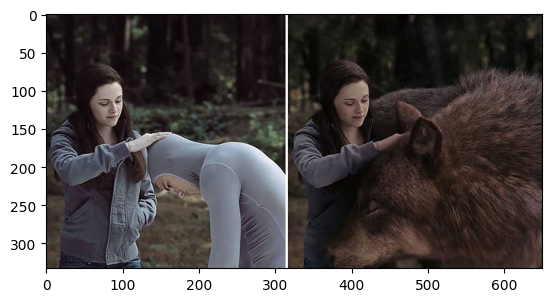

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063}, {'x': 0.1723076923076923, 'y': 0.45345345345345345}], 'imageWidth': 650, 'imageHeight': 333}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913}, {'x': 0.6584615384615384, 'y': 0.46846846846846846}], 'imageWidth': 650, 'imageHeight': 333}]


In [ ]:
plt.imshow(data[0][0], cmap='gray')
plt.show()
print(data[0][1])

Part 1.1 b - Split the data into Features(X) & labels(Y). Unify shape of all the images.

In [ ]:
# To extract featues and labels
NO_OF_IMAGES = 393
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

X = np.zeros((NO_OF_IMAGES, IMAGE_HEIGHT, IMAGE_WIDTH, 3))
Y = np.zeros((NO_OF_IMAGES, IMAGE_HEIGHT, IMAGE_WIDTH))

for i in range(NO_OF_IMAGES):
    #Features
    img = data[i][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH))
    if img.shape != (224,224,3):
      img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    X[i] = preprocess_input(np.array(img, dtype=np.float32))

    #Labels
    for j in data[i][1]:
        x1 = int(j["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(j["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(j["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(j["points"][1]['y'] * IMAGE_HEIGHT)
        Y[i][y1:y2, x1:x2] = 1

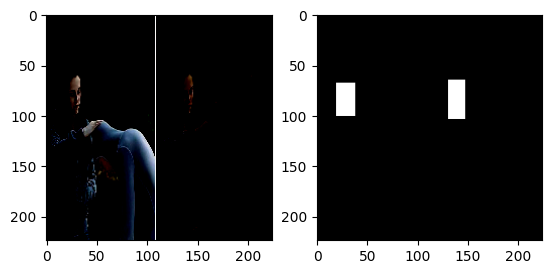

In [ ]:
#displaying sample image
plt.subplot(1,2,1)
plt.imshow(X[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(Y[0], cmap='gray')
plt.show()

Part 1.1 c - Split the data into train and test [400:9].

In [ ]:
## Since there are only 393 images, splitting into 384:9
#Training data
X_train = X[:384]
Y_train = Y[:384]
print ("X_train size ",X_train.shape)
print ("Y_train size ",Y_train.shape)
#Test data
X_test = X[384:]
Y_test = Y[384:]
print ("X_test size ",X_test.shape)
print ("Y_test size ",Y_test.shape)

X_train size  (384, 224, 224, 3)
Y_train size  (384, 224, 224)
X_test size  (9, 224, 224, 3)
Y_test size  (9, 224, 224)


Part 1.1 d - Select random image from the train data and display original image and masked image.

198


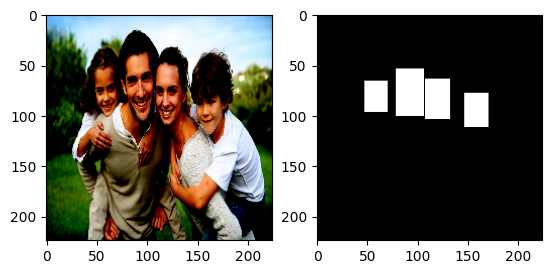

In [ ]:
#Setting random integer
n = random.randint(1, 384)
print (n)

# Printing original and masked versions of randon image from the training dataset
plt.subplot(1,2,1)
plt.imshow(X_train[n], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(Y_train[n], cmap='gray')
plt.show()

Part 1.2 a - Design a face mask detection model.

In [ ]:
# Building Base model using pretrained MobileNet and mirroring Conv layers to create UNet architecture
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer("conv_pw_1_relu").output
    block2 = model.get_layer("conv_pw_3_relu").output
    block3 = model.get_layer("conv_pw_5_relu").output
    block4 = model.get_layer("conv_pw_11_relu").output
    block5 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block5), block4])
    x = Concatenate()([UpSampling2D()(x), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)

    return Model(inputs=model.input, outputs=x)

Part 1.2 b - Design your own Dice Coefficient and Loss function.

In [ ]:
#Dice Coefficient Function
def dice_coefficient(y_true, y_pred):
    numerator = 2 * reduce_sum(y_true * y_pred)
    denominator = reduce_sum(y_true + y_pred)

    return numerator / (denominator + epsilon())

#Dice Loss Function
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

Part 1.2 c - Train and tune the model as required.

In [ ]:
# Building the model
base_model = create_model()
base_model.summary()

17225924/17225924 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)         128       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           

In [ ]:
# Defining Optimizers
optimizer = Adam(learning_rate=1e-4, amsgrad=False)
base_model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [ ]:
# Setting Checkpoints & call backs
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True, save_weights_only=True)
stop = EarlyStopping(monitor="loss", patience=5)
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)

In [ ]:
#Fitting the model
base_model_history = base_model.fit(X_train, Y_train, epochs=10, batch_size=1, verbose=1, callbacks=[checkpoint,reduce_lr,stop],validation_split=0.3)

Epoch 1/10
268/268 [==============================] - ETA: 0s - loss: 1.3796 - dice_coefficient: 0.4300
Epoch 1: loss improved from inf to 1.37960, saving model to model-1.38.h5
268/268 [==============================] - 39s 57ms/step - loss: 1.3796 - dice_coefficient: 0.4300 - val_loss: 1.5245 - val_dice_coefficient: 0.3913 - lr: 1.0000e-04
Epoch 2/10
268/268 [==============================] - ETA: 0s - loss: 0.7734 - dice_coefficient: 0.6108
Epoch 2: loss improved from 1.37960 to 0.77339, saving model to model-0.77.h5
268/268 [==============================] - 14s 51ms/step - loss: 0.7734 - dice_coefficient: 0.6108 - val_loss: 1.2896 - val_dice_coefficient: 0.4416 - lr: 1.0000e-04
Epoch 3/10
268/268 [==============================] - ETA: 0s - loss: 0.6005 - dice_coefficient: 0.6717
Epoch 3: loss improved from 0.77339 to 0.60045, saving model to model-0.60.h5
268/268 [==============================] - 14s 51ms/step - loss: 0.6005 - dice_coefficient: 0.6717 - val_loss: 1.1069 - val_di

Part 1.2 d - Evaluate and share insights on performance of the model.

 Model Performance on Test data ->
************************************************************
1/1 [==============================] - 2s 2s/step - loss: 0.6777 - dice_coefficient: 0.6228


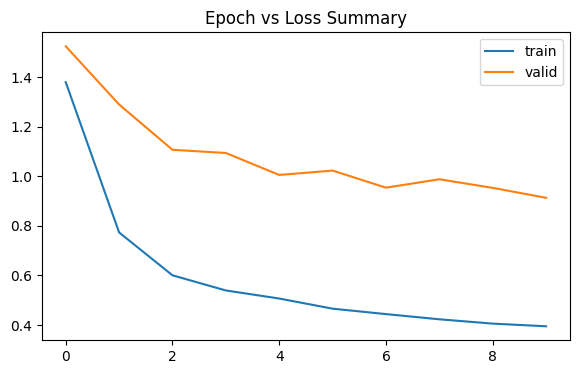

In [ ]:
# Capturing learning history per epoch
hist = pd.DataFrame(base_model_history.history)
hist['epoch'] = base_model_history.epoch


plt.figure(figsize=(15,4))
# Plotting Train & Validation Loss at different epochs
plt.subplot(1, 2, 1)
plt.title('Epoch vs Loss Summary')
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid"))

#Printing results
print (" Model Performance on Test data ->")
print ("*"*60)
results = base_model.evaluate(X_test, Y_test)

Tuning the model by adjusting below parameters
*   Learning Rate = 0.0010
*   Batch Size = 4
*   Epoch = 25

In [ ]:
tuned_model = create_model()
optimizer_t = Adam(learning_rate=1e-3,amsgrad=False)
tuned_model.compile(loss=loss, optimizer=optimizer_t, metrics=[dice_coefficient])
tuned_model_history = tuned_model.fit(X_train, Y_train, epochs=25, batch_size=4, verbose=1, callbacks=[checkpoint,reduce_lr,stop],validation_split=0.3)

Epoch 1/25
67/67 [==============================] - ETA: 0s - loss: 1.1842 - dice_coefficient: 0.5233
Epoch 1: loss did not improve from 0.39490
67/67 [==============================] - 29s 206ms/step - loss: 1.1842 - dice_coefficient: 0.5233 - val_loss: 1.6989 - val_dice_coefficient: 0.4351 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 0.6806 - dice_coefficient: 0.6503
Epoch 2: loss did not improve from 0.39490
67/67 [==============================] - 13s 188ms/step - loss: 0.6806 - dice_coefficient: 0.6503 - val_loss: 1.6326 - val_dice_coefficient: 0.4239 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 0.5582 - dice_coefficient: 0.6959
Epoch 3: loss did not improve from 0.39490
67/67 [==============================] - 12s 182ms/step - loss: 0.5582 - dice_coefficient: 0.6959 - val_loss: 1.3991 - val_dice_coefficient: 0.4417 - lr: 0.0010
Epoch 4/25
67/67 [==============================] - ETA: 0s - loss: 0.4736 - dice_

 Model Performance on Test data ->
************************************************************
1/1 [==============================] - 1s 899ms/step - loss: 0.5909 - dice_coefficient: 0.7048


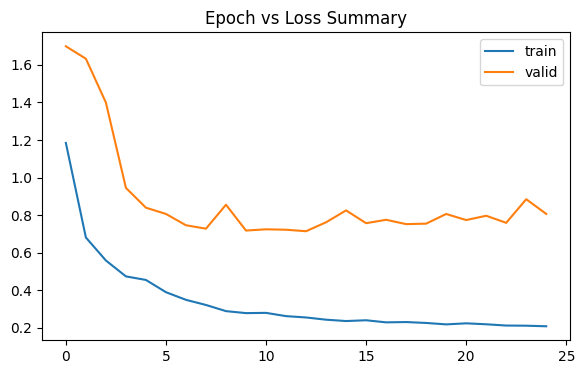

In [ ]:
# Capturing learning history per epoch
hist_tuned = pd.DataFrame(tuned_model_history.history)
hist_tuned['epoch'] = tuned_model_history.epoch

plt.figure(figsize=(15,4))
# Plotting Train & Validation Loss at different epochs
plt.subplot(1, 2, 1)
plt.title('Epoch vs Loss Summary')
plt.plot(hist_tuned['loss'])
plt.plot(hist_tuned['val_loss'])
plt.legend(("train" , "valid"))

#Printing results
print (" Model Performance on Test data ->")
print ("*"*60)
results = tuned_model.evaluate(X_test, Y_test)

**Insights**

**Base Model**
*   Extended MobileNet by mirror layers to create UNet architecture
*   Used Adam Optimizer with Learning rate '0.0001' with Batch size '1' and Epoch '10'
*   Model performed relatively well with dice loss of 0.38 with training dataset / .70 on test dataset.
*   Model was clearly overfit.


**Updated Model**
*   Tuned the model by increasing the Epoch '25', Batch size '4', and learning rate '0.001'
*   Model performance slightly improved with dice loss of 0.20 with training dataset and .55 on test dataset
*   Overfit reduced slightly.

**Model can be tuned further provided more computational power is available.**

Part 1.3 - Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image.

1/1 [==============================] - 1s 814ms/step


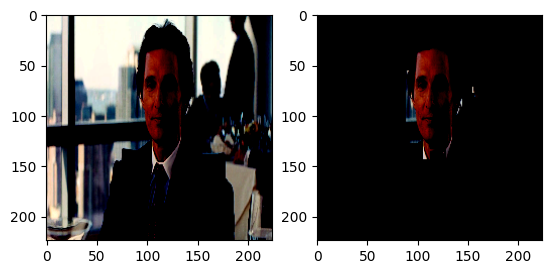

In [ ]:
#Setting random integer
r = 3

#Printing Original Image
plt.subplot(1,2,1)
plt.imshow(X_test[r], cmap='gray')

#Predicting random image
pred_on_test = cv2.resize(1.0*(tuned_model.predict(x=np.array([X_test[r]]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

#Overlaying the mask
image_test = X_test[r]
image_test[:,:,0] = pred_on_test*X_test[r][:,:,0]
image_test[:,:,1] = pred_on_test*X_test[r][:,:,1]
image_test[:,:,2] = pred_on_test*X_test[r][:,:,2]
out_image_test = image_test

#Printing Original Image with Face mask overlayed
plt.subplot(1,2,2)
plt.imshow(out_image_test, cmap='gray')
plt.show()

Summary

Tuned UNet (with pretrained MobileNet), performed well in recognizing the Faces from the test dataset.

Final parameters:
*   Tuned the model by increasing the Epoch '25', Batch size '4', and learning rate '0.001'
*   Model performance slightly improved with dice loss of 0.20 with training dataset and .50 on test dataset

# PART - B

• DOMAIN: Entertainment

• CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription
basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on
the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer
vision and multimedia experts who need to detect faces from screen shots from the movie scene. The data labelling is already done. Since there higher time complexity is involved in the

• DATA DESCRIPTION: The dataset comprises of face images.

• PROJECT OBJECTIVE: To create an image dataset to be used by AI team build an image classifier data. Profile images of people are given.

Part 2.1 a Read/import images from folder ‘training_images’.

In [ ]:
#Extracting images from the ZIP file
images_zip_path = project_path + "training_images-20211126T092819Z-001.zip"
with ZipFile(images_zip_path, 'r') as z:
  z.extractall()

#Getting the image list
img_list = os.listdir('training_images')
print(img_list)

['real_00174.jpg', 'real_00944.jpg', 'real_00543.jpg', 'real_00806.jpg', 'real_00621.jpg', 'real_00208.jpg', 'real_00904.jpg', 'real_00245.jpg', 'real_00199.jpg', 'real_00703.jpg', 'real_00940.jpg', 'real_00067.jpg', 'real_00908.jpg', 'real_00560.jpg', 'real_00611.jpg', 'real_00233.jpg', 'real_00355.jpg', 'real_00179.jpg', 'real_00107.jpg', 'real_00673.jpg', 'real_00060.jpg', 'real_00405.jpg', 'real_00833.jpg', 'real_00445.jpg', 'real_00487.jpg', 'real_00195.jpg', 'real_00662.jpg', 'real_00291.jpg', 'real_00626.jpg', 'real_00929.jpg', 'real_00592.jpg', 'real_00888.jpg', 'real_00412.jpg', 'real_00439.jpg', 'real_00219.jpg', 'real_00692.jpg', 'real_00807.jpg', 'real_00739.jpg', 'real_01055.jpg', 'real_00991.jpg', 'real_00728.jpg', 'real_00599.jpg', 'real_00129.jpg', 'real_00506.jpg', 'real_00335.jpg', 'real_00834.jpg', 'real_00045.jpg', 'real_00778.jpg', 'real_00458.jpg', 'real_00979.jpg', 'real_00753.jpg', 'real_00693.jpg', 'real_00782.jpg', 'real_00808.jpg', 'real_01030.jpg', 'real_007

Part 2.1 b - Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images.

1091
[ 531    7 1089  296  300   21  766  592  381  453]


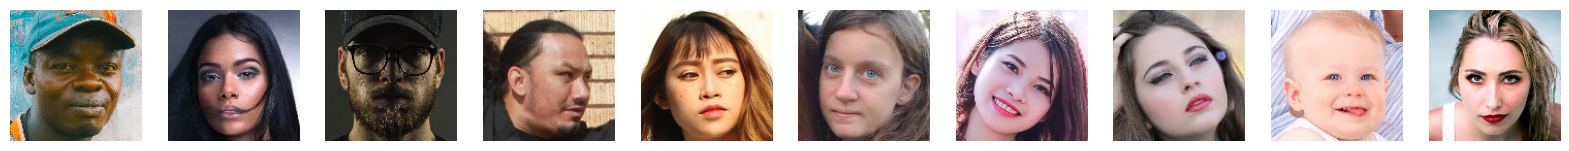

In [ ]:
ImgList = []

# Read each image inside training_images folder one by one
for i in os.listdir(os.path.join('training_images')):
  temp = cv2.imread(os.path.join('training_images', i))
  temp = cv2.resize(temp, (128, 128))
  temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
  ImgList.append(temp)

print(len(ImgList))

# Visualizing 10 random images from the file
rand = np.random.randint(0, len(ImgList), 10) # Generating 10 random numbers out of total number of flowers
print(rand)
plt.figure(figsize=(20, 20))
for i,j in enumerate(rand):
    plt.subplot(1, len(rand), i+1)
    plt.imshow(ImgList[j])
    plt.axis('off')
plt.show()

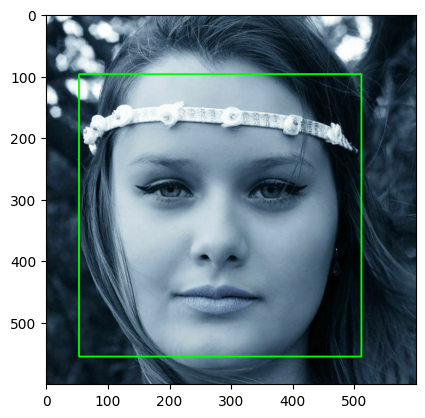

In [ ]:
#Looping thru all the images and detecting face using OpenCV library Haarcascades function
for i in os.listdir(os.path.join('training_images')):
  train_img = cv2.imread(os.path.join('training_images', i))
  gray_img = cv2.cvtColor(train_img, cv2.COLOR_RGB2GRAY)
  haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  faces_rect = haar_cascade.detectMultiScale(gray_img, 1.1, 10)
  for (x, y, w, h) in faces_rect:
	  train_img_box = cv2.rectangle(train_img, (x, y), (x+w, y+h), (0, 255, 0), 2)

plt.imshow(train_img_box)

Part 2.1 c - From the same loop above, extract metadata of the faces and write into a DataFrame.

In [ ]:
x_pos = []
y_pos = []
width = []
height = []
face_cnt = []
img_name = []

for i in os.listdir(os.path.join('training_images')):
  train_img = cv2.imread(os.path.join('training_images', i))
  gray_img = cv2.cvtColor(train_img, cv2.COLOR_BGR2GRAY)
  haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  faces_rect = haar_cascade.detectMultiScale(gray_img, 1.1, 10)
  j = 0
  for (x, y, w, h) in faces_rect:
    j = j + 1
    train_img_box = cv2.rectangle(train_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    img_name.append(i)
    x_pos.append(x)
    y_pos.append(y)
    width.append(w)
    height.append(h)
    face_cnt.append(j)

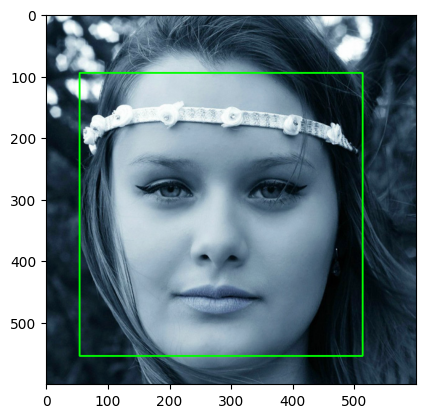

In [ ]:
plt.imshow(train_img_box)

Part 2.1 d - Save the output Dataframe in .csv format..

In [ ]:
# Saving in a pandas dataframe
output_df = pd.DataFrame({'x' : x_pos,'y' : y_pos,'w' : width,'h' : height,'Total_Faces' : face_cnt,'Image_Name' : img_name})
output_df

,x,y,w,h,Total_Faces,Image_Name
0,89,102,428,428,1,real_00174.jpg
1,23,147,437,437,1,real_00944.jpg
2,85,147,417,417,1,real_00806.jpg
3,105,175,406,406,1,real_00621.jpg
4,102,123,421,421,1,real_00208.jpg
...,...,...,...,...,...,...
785,96,123,420,420,1,real_00044.jpg
786,58,170,379,379,1,real_00915.jpg
787,78,103,418,418,1,real_00324.jpg
788,113,140,401,401,1,real_00756.jpg


In [ ]:
#Saving dataframe in a CSV file
output_df.to_csv('my_data.csv', index=False)

**Summary**

Using Open source library 'haarcascades', trained the provided images to detect faces and extract the coordinates in a CSV file.

# PART - C
• DOMAIN: Face Recognition

• CONTEXT: Company X intends to build a face identification model to recognise human faces.

• DATA DESCRIPTION: The dataset comprises of images and its mask where there is a human face.

• PROJECT OBJECTIVE: Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken
from 'Pinterest' and aligned using dlib library.

Part 3.1 a - Unzip, read and Load data(‘PINS.zip’) into session

In [ ]:
#Extracting images from the ZIP file
images_zip_path = project_path + "PINS.zip"
with ZipFile(images_zip_path, 'r') as p:
  p.extractall()

  #Getting the folders list
  img_list = os.listdir('PINS')
  print(img_list)

['pins_Robert Knepper', 'pins_Dave Franco', 'pins_Betsy Brandt', 'pins_zendaya', 'pins_elon musk', 'pins_Pedro Alonso', 'pins_Henry Cavil', 'pins_Jason Momoa', 'pins_drake', 'pins_Alvaro Morte', 'pins_Maisie Williams', 'pins_Emily Bett Rickards', 'pins_Gwyneth Paltrow', 'pins_Kumail Nanjiani', 'pins_tati gabrielle', 'pins_elizabeth olsen face', 'pins_William Fichtner', 'pins_margot robbie face', 'pins_kristen stewart face', 'pins_Chris Evans', 'pins_Natalie Portman ', 'pins_Dominic Purcell', 'pins_maria pedraza', 'pins_Danielle Panabaker', 'pins_Jesse Eisenberg', 'pins_Cobie Smulders', 'pins_Chris Pratt', 'pins_Rami Melek', 'pins_RJ Mitte', 'pins_rihanna', 'pins_millie bobby brown', 'pins_david mazouz', 'pins_Kit Harington', 'pins_Jeremy Renner', 'pins_sean pertwee', 'pins_gal gadot face', 'pins_alexandra daddario', 'pins_Willa Holland', 'pins_Aaron Paul', 'pins_kiernan shipka ', 'pins_shakira', 'pins_Krysten Ritter', 'pins_Brenton Thwaites', 'pins_dua lipa face', 'pins_Neil Patrick Ha

Part 3.1 b - Write function to create metadata of the image.

In [ ]:
# Function to create metadata
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)

Part 3.1 c - Write a loop to iterate through each and every image and create metadata for all the images.

In [ ]:
# Function to Load metadata
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

In [ ]:
# Invoking load_metadata function to obtain metadata from all images
img_metadata = load_metadata('PINS')
img_metadata

array([PINS/pins_Robert Knepper/Robert Knepper41.jpg,
       PINS/pins_Robert Knepper/Robert Knepper90.jpg,
       PINS/pins_Robert Knepper/Robert Knepper68.jpg, ...,
       PINS/pins_taylor swift/taylor swift50.jpg,
       PINS/pins_taylor swift/taylor swift41.jpg,
       PINS/pins_taylor swift/taylor swift49.jpg], dtype=object)

In [ ]:
# Converting BGR image to RGB
def load_image(image):
  image = cv2.imread(image)
  # Convert BGR to RGB
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # Display the converted image
  return image_rgb

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
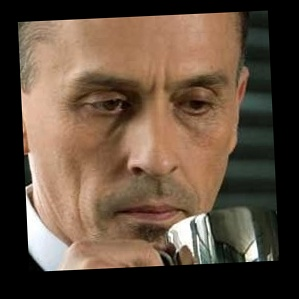

In [ ]:
load_image(img_metadata[0].image_path())

Part 3.1 d - Generate Embeddings vectors on the each face in the dataset.

In [ ]:
#Building the model
def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [ ]:
# Assigning the given weights
model = vgg_face()
model.load_weights("/content/drive/MyDrive/DataScience/Computer Vision/vgg_face_weights.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPaddin  (None, 226, 226, 3)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPadd  (None, 226, 226, 64)      0         
 ing2D)                                                          
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                        

In [ ]:
# Defining the VGG Face descriptor
print(model.layers[0].input)
print(model.layers[-2].output)
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='zero_padding2d_input'), name='zero_padding2d_input', description="created by layer 'zero_padding2d_input'")
KerasTensor(type_spec=TensorSpec(shape=(None, 2622), dtype=tf.float32, name=None), name='flatten/Reshape:0', description="created by layer 'flatten'")


In [ ]:
# Get embedding vector for first image in the metadata using the pre-trained model
img_path = img_metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 2s 2s/step
(2622,)


In [ ]:
# Iterating through images to obtain the embeddings
embeddings = np.zeros((img_metadata.shape[0], 2622))

for i, m in enumerate(img_metadata):
  img_path = m.image_path()
  img = load_image(img_path)

  img = (img / 255.).astype(np.float32)

  img = cv2.resize(img, dsize = (224,224))

  # Getting the embedding vector for the above image using vgg_face_descriptor model
  embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 30ms/step


Part 3.1 e - Build distance metrics for identifying the distance between two similar and dissimilar images.

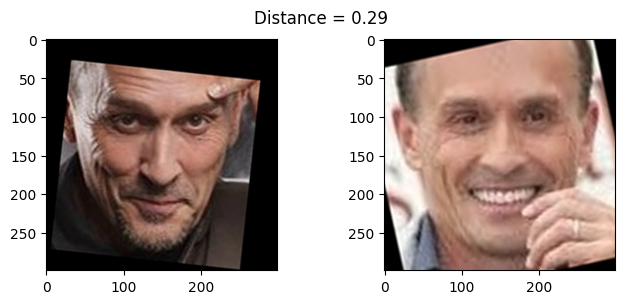

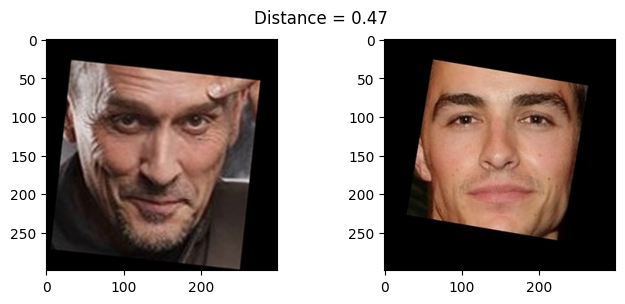

In [ ]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(img_metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(img_metadata[idx2].image_path()));

show_pair(2, 3)
show_pair(2, 180)

Insights

*   Images 2 and 3 are recognized as similar images with distance of 0.19
*   Images 2 and 180 are recognized as dissimilar images with a distance of 0.71 as expected.



Part 3.1 f - Use PCA for dimensionality reduction.

In [ ]:
train_idx = np.arange(img_metadata.shape[0]) % 9 != 0
test_idx = np.arange(img_metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities
X_test = embeddings[test_idx]

targets = np.array([m.name for m in img_metadata])
y_train = targets[train_idx]
y_test = targets[test_idx]

In [ ]:
print ("X_train[0] - ",X_train[0])
print ("X_test[0] - ",X_test[0])
print ("y_train[0] - ",y_train[0])
print ("y_test[0] - ",y_test[0])

X_train[0] -  [ 0.01041974 -0.00338019 -0.0041309  ... -0.00661333 -0.01204382
  0.00115932]
X_test[0] -  [ 0.00713255 -0.01353642 -0.00096712 ...  0.00429679 -0.00948952
  0.00794277]
y_train[0] -  pins_Robert Knepper
y_test[0] -  pins_Robert Knepper


In [ ]:
# Normalizing Features
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.fit_transform(X_test)

# Encoding Laels
from sklearn.preprocessing import LabelEncoder
lab = LabelEncoder()
y_train = lab.fit_transform(y_train)
y_test = lab.fit_transform(y_test)

In [ ]:
print ("X_train[0] - ",X_train[0])
print ("X_test[0] - ",X_test[0])
print ("y_train[0] - ",y_train[0])
print ("y_test[0] - ",y_test[0])

X_train[0] -  [-0.0422705  -0.25987502 -0.67054315 ...  0.7363924  -1.69611301
 -0.94778302]
X_test[0] -  [-0.39182196 -1.12938392 -0.35477801 ...  1.81822806 -1.42583949
 -0.41741356]
y_train[0] -  48
y_test[0] -  48


In [ ]:
# Applying dimentionality reduction technique (PCA)
pca_comp = 128
pca = PCA(pca_comp,random_state=101)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

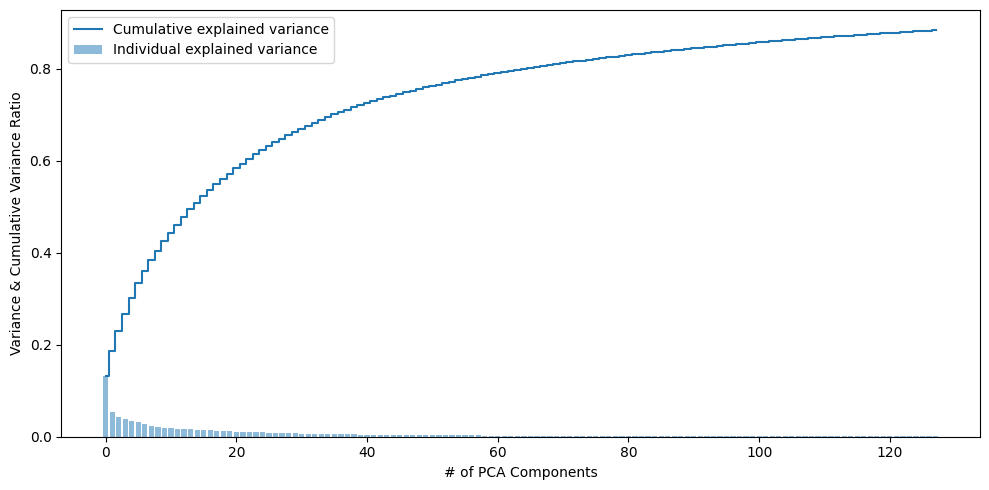

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(list(range(0,pca_comp)),pca.explained_variance_ratio_,alpha=0.5, align='center',label = 'Individual explained variance')
plt.step(list(range(0,pca_comp)),np.cumsum(pca.explained_variance_ratio_), where='mid',label = 'Cumulative explained variance')
#plt.axhline(y=0.90, color='r', linestyle='-')
plt.ylabel('Variance & Cumulative Variance Ratio')
plt.xlabel('# of PCA Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

Part 3.1 g - Build an SVM classifier in order to map each image to its right person.

In [ ]:
# SVM - Model

#SVM = SVC(C=1,gamma='auto',kernel='linear',random_state = 101)

parameters = {'kernel': ('linear','rbf'), 'C': [0.001,1,100], 'gamma': [0.1,1,1000]}
svc_tune = SVC(random_state=42)

clf = GridSearchCV(svc_tune, parameters, cv=10)

best_svc_model = clf.fit(X_train_pca,y_train)

print("Best Params : ",best_svc_model.best_params_)
print("Best Score : ",best_svc_model.best_score_)

#SVM.fit(X_train_pca, y_train)
#SVM_Accuracy = SVM.score(X_train_pca, y_train)
#print("Train Accuracy : ", SVM_Accuracy)
#SVM_Accuracy = SVM.score(X_test_pca, y_test)
#print("Test Accuracy : ", SVM_Accuracy)


Best Params :  {'C': 0.001, 'gamma': 0.1, 'kernel': 'linear'}
Best Score :  0.9594692879409601


Part 3.1 h - Import and display the the test images.

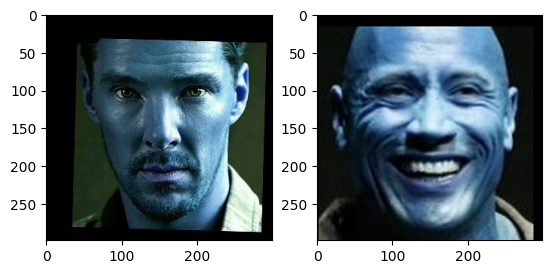

In [ ]:
# Importing Test Images
Test_Imgs = []
test_1 = '/content/drive/MyDrive/DataScience/Computer Vision/Benedict Cumberbatch9.jpg'
test_1_img = cv2.imread(test_1,cv2.IMREAD_UNCHANGED)
#test_1_img = cv2.cvtColor(test_1_img, cv2.COLOR_BGR2RGB)
Test_Imgs.append(test_1_img)

test_2 =  '/content/drive/MyDrive/DataScience/Computer Vision/Dwayne Johnson4.jpg'
test_2_img = cv2.imread(test_2,cv2.IMREAD_UNCHANGED)
#test_2_img = cv2.cvtColor(test_2_img, cv2.COLOR_BGR2RGB)
Test_Imgs.append(test_2_img)

# Displaying the image
plt.subplot(121)
plt.imshow(test_1_img)
plt.subplot(122)
plt.imshow(test_2_img)

Part 3.1 i - Use the trained SVM model to predict the face on both test images.

1/1 [==============================] - 0s 24ms/step


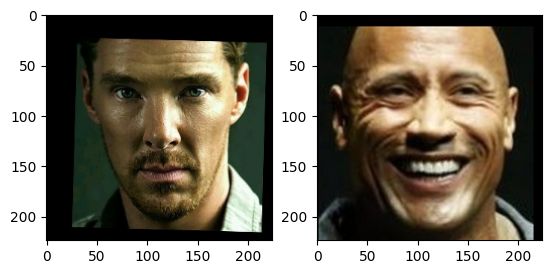

In [ ]:
# Iterating through two images to obtain the embeddings
embed = np.zeros((2, 2622))

for i, m in enumerate(Test_Imgs):

  img = cv2.cvtColor(m, cv2.COLOR_BGR2RGB)
  img = (img / 255.).astype(np.float32)

  img = cv2.resize(img, dsize = (224,224))

  if i == 0:
    plt.subplot(121)
    plt.imshow(img)
    test1 = img
  else:
    plt.subplot(122)
    plt.imshow(img)
    test2 = img

  embed[i] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]

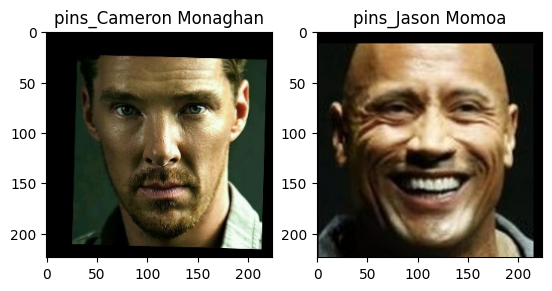

In [ ]:
# Standardizing test images
embed = std.fit_transform(embed)

# PCA on test images
test_pca = pca.transform(embed)

#Predicting test images
test_pred = best_svc_model.predict(test_pca)
test_pred

#Decode Labels
decoded_test_pred = lab.inverse_transform(test_pred)
decoded_test_pred

# Displaying Test Predictions
plt.subplot(121)
plt.title(decoded_test_pred[0])
plt.imshow(test1)

plt.subplot(122)
plt.title(decoded_test_pred[1])
plt.imshow(test2)

**Summary**

Tuned SVM model with embeddings extracted during pretrained VGG model, didnt perform well on the test predictions.
Due to compute limitations unable to try other options.

In [ ]:
#!apt-get install jupyter-nbconvert
#!jupyter nbconvert --to html '/content/drive/MyDrive/DataScience/NLP/Project_NLP.ipynb'

!jupyter nbconvert --ExecutePreprocessor.store_widget_state=False --to html '/content/drive/MyDrive/DataScience/NLP/Project_NLP.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/DataScience/NLP/Project_NLP.ipynb to html
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 423, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 597, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 560, in convert_single_notebook
    output, resources = self.export_single_notebook(
  File "/usr/local/lib/python3.10/dist-packages/n